# Testing Anomaly Model with Normalized Features

In the main modeling code, I decided to keep the features unnormalized as to better capture the outliers and anomalies of the dataset. I wanted to test the same model, and the comparison LOF model, using the normalized verison of the data. Results were essentially the same, showing no difference in normalizing the data versus keeping the data as is.

In [6]:
import os
import pandas as pd

# Define the folder containing the processed data
processed_data_folder = "../processed_data"

# Load all patient DataFrame .pkl files
patient_dataframes = {}
for file in os.listdir(processed_data_folder):
    if file.endswith("_processed.pkl"):
        patient_id = file.split("_")[0]  # Extract patient ID from the filename
        patient_dataframes[patient_id] = pd.read_pickle(os.path.join(processed_data_folder, file))

# Example: Print the keys (patient IDs) and the first few rows of one DataFrame
print(f"Loaded patient IDs: {list(patient_dataframes.keys())}")
print(patient_dataframes[list(patient_dataframes.keys())[0]].head())

Loaded patient IDs: ['S10', 'S11', 'S12', 'S13', 'S14', 'S15', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9']
   bvp_mean    bvp_std    bvp_energy     bvp_ptp            bvp_freq_1  \
0 -3.120449  97.081244  2.415233e+06  781.477358  [15.237045471108313]   
1 -1.325391  97.497728  2.433936e+06  781.511716   [1.724030308405311]   
2 -0.445313  97.592194  2.438255e+06  781.509878  [12.279975717297718]   
3 -0.223027  97.597714  2.438493e+06  781.545981  [18.662209905605682]   
4  3.138984  18.017857  8.563108e+04   79.709171    [27.3308483912108]   

             bvp_freq_2            bvp_freq_3  bvp_skewness  bvp_kurtosis  \
0    [4.28060767761561]   [6.076547474360892]     -2.914617     13.051342   
1   [9.573453129335247]   [9.655299243621165]     -2.929738     12.993734   
2  [26.098770576458392]  [27.022712527519346]     -2.947966     13.037922   
3   [34.08213309207644]   [47.48653642239944]     -2.954025     13.061178   
4  [43.155205345463806]  [37.425938193693035]     -0.

In [8]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Combine all patient data into a single DataFrame
combined_data = pd.concat(
    [df.assign(patient_id=patient_id) for patient_id, df in patient_dataframes.items()],
    ignore_index=True,
)

# Select numerical columns for normalization (exclude non-numerical/contextual features)
numerical_columns = combined_data.select_dtypes(include=['float64', 'int64']).columns
numerical_columns = numerical_columns.drop(["activity", "bpm"], errors="ignore")  # Exclude contextual features

# Initialize the scaler
scaler = StandardScaler()

# Normalize the numerical features
normalized_features = scaler.fit_transform(combined_data[numerical_columns])

# Convert normalized features back to a DataFrame
normalized_df = pd.DataFrame(normalized_features, columns=numerical_columns, index=combined_data.index)

# Replace the original numerical columns with the normalized ones
combined_data.update(normalized_df)

# Print the first few rows of the normalized data
print(combined_data.head())

from sklearn.ensemble import IsolationForest


# Select numerical columns for anomaly detection
numerical_columns2 = combined_data.select_dtypes(include=['float64', 'int64']).columns
numerical_columns2 = numerical_columns2.drop("activity")  # Exclude the activity column
X = combined_data[numerical_columns2]

# Initialize and fit Isolation Forest
isolation_forest = IsolationForest(n_estimators=500, contamination=0.01, random_state=42)
combined_data['anomaly'] = isolation_forest.fit_predict(X)

# Save anomalies for analysis
anomalies = combined_data[combined_data['anomaly'] == -1]
print(f"Number of anomalies detected: {len(anomalies)}")

   bvp_mean   bvp_std  bvp_energy   bvp_ptp            bvp_freq_1  \
0 -0.818320  0.585751    0.219478  1.325103  [15.237045471108313]   
1 -0.347560  0.594663    0.226224  1.325220   [1.724030308405311]   
2 -0.116756  0.596684    0.227782  1.325214  [12.279975717297718]   
3 -0.058461  0.596802    0.227868  1.325337  [18.662209905605682]   
4  0.823238 -1.106038   -0.620809 -1.065109    [27.3308483912108]   

             bvp_freq_2            bvp_freq_3  bvp_skewness  bvp_kurtosis  \
0    [4.28060767761561]   [6.076547474360892]     -4.223512      4.641628   
1   [9.573453129335247]   [9.655299243621165]     -4.247367      4.619344   
2  [26.098770576458392]  [27.022712527519346]     -4.276123      4.636437   
3   [34.08213309207644]   [47.48653642239944]     -4.285683      4.645433   
4  [43.155205345463806]  [37.425938193693035]     -0.261700     -0.712483   

   acc_x_mean  ...  acc_z_std  acc_magnitude_mean  acc_magnitude_std  \
0   -0.966009  ...  -1.129134           -0.710656 

patient_id
S1      31
S2      39
S3      37
S4      10
S5     139
S6       9
S7       1
S8      77
S9     144
S10      3
S11     10
S12     87
S13     15
S14     45
dtype: int64


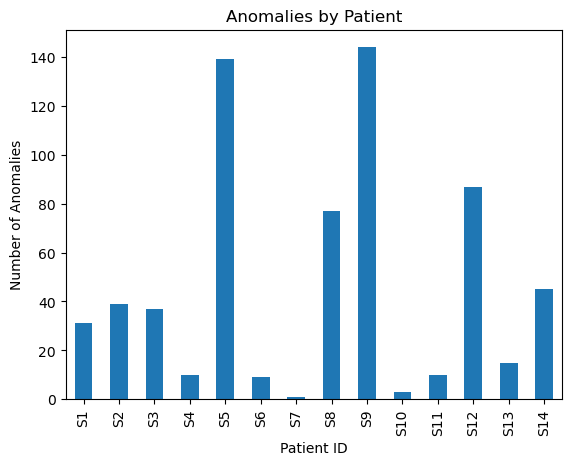

In [10]:
import matplotlib.pyplot as plt

# Count anomalies by patient
anomalies_by_patient = combined_data[combined_data["anomaly"] == -1].groupby("patient_id").size()

# Sort patient IDs numerically by extracting the numeric part
anomalies_by_patient = anomalies_by_patient.sort_index(key=lambda x: x.str.extract(r'(\d+)').astype(int)[0])

# Print and plot the anomalies by patient
print(anomalies_by_patient)
anomalies_by_patient.plot(kind="bar", title="Anomalies by Patient")
plt.xlabel("Patient ID")
plt.ylabel("Number of Anomalies")
plt.show()

In [9]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=160, contamination=0.01)
lof_labels = lof.fit_predict(X)

lof_anomalies = combined_data[lof_labels == -1]

# Compare with Isolation Forest results
print(f"Number of anomalies detected by LOF: {len(lof_anomalies)}")
print(f"Overlap with Isolation Forest anomalies: {len(set(anomalies.index) & set(lof_anomalies.index))}")

c:\Users\darte\anaconda3\envs\healthcare_anomaly\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\darte\anaconda3\envs\healthcare_anomaly\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\darte\anaconda3\envs\healthcare_anomaly\lib\subprocess.py", line 493, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\darte\anaconda3\envs\healthcare_anomaly\lib\subprocess.py", line 858, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\darte\anaconda3\envs\healthcare_anomaly\lib\subprocess.py", line 1327, in _exe

Number of anomalies detected by LOF: 647
Overlap with Isolation Forest anomalies: 238


In [3]:
from sklearn.ensemble import IsolationForest
import pandas as pd

# Combine all patient data into a single DataFrame
combined_data = pd.concat(
    [df.assign(patient_id=patient_id) for patient_id, df in patient_dataframes.items()],
    ignore_index=True
)
# Select numerical columns for anomaly detection
numerical_columns = combined_data.select_dtypes(include=['float64', 'int64']).columns
numerical_columns = numerical_columns.drop("activity")  # Exclude the activity column
X = combined_data[numerical_columns]

# Initialize and fit Isolation Forest
isolation_forest = IsolationForest(n_estimators=500, contamination=0.01, random_state=42)
combined_data['anomaly'] = isolation_forest.fit_predict(X)

# Save anomalies for analysis
anomalies = combined_data[combined_data['anomaly'] == -1]
print(f"Number of anomalies detected: {len(anomalies)}")

Number of anomalies detected: 647


In [11]:
combined_data.head()

,bvp_mean,bvp_std,bvp_energy,bvp_ptp,bvp_freq_1,bvp_freq_2,bvp_freq_3,bvp_skewness,bvp_kurtosis,acc_x_mean,...,acc_magnitude_mean,acc_magnitude_std,bvp_acc_corr_mean,temp_mean,temp_std,temp_range,activity,bpm,patient_id,anomaly
0,-0.818320,0.585751,0.219478,1.325103,[15.237045471108313],[4.28060767761561],[6.076547474360892],-4.223512,4.641628,-0.966009,...,-0.710656,-1.013750,-0.761454,-1.355611,-0.371843,-0.001949,0.0,64.282356,S10,1
1,-0.347560,0.594663,0.226224,1.325220,[1.724030308405311],[9.573453129335247],[9.655299243621165],-4.247367,4.619344,-0.956624,...,-0.707764,-1.013948,-0.656804,-1.349405,0.286253,-0.001949,0.0,63.349710,S10,1
2,-0.116756,0.596684,0.227782,1.325214,[12.279975717297718],[26.098770576458392],[27.022712527519346],-4.276123,4.636437,-0.938541,...,-0.703497,-1.016984,-0.623979,-1.343888,0.509403,-0.001949,0.0,64.568477,S10,1
3,-0.058461,0.596802,0.227868,1.325337,[18.662209905605682],[34.08213309207644],[47.48653642239944],-4.285683,4.645433,-0.911989,...,-0.705882,-1.035650,-0.351648,-1.338371,-0.243310,-0.001949,0.0,64.671709,S10,1
4,0.823238,-1.106038,-0.620809,-1.065109,[27.3308483912108],[43.155205345463806],[37.425938193693035],-0.261700,-0.712483,-0.894592,...,-0.711045,-1.036345,-1.998743,-1.334923,-1.288189,-0.892952,0.0,65.310046,S10,1
